In [1]:
import os
os.chdir("..")
os.chdir("src")
from evaluate_lda import get_files, coherence_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from typing import  List
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc
from lda_opt import LDAOptimization
from lda import LDASingleModel
os.chdir("..")

[nltk_data] Downloading package rslp to
[nltk_data]     /home/brunodifranco/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
# optimizer = LDAOptimization(
#     nlp_normalization_method="stemmer",  # Method to choose: either stemmer or lemmatization
#     n_filter=0,  # Minimum frequency to retain a token in the dictionary. e.g if n_filter=0 all tokens will be kept
#     n_trials=80,  # Number of trials for optimization
# )
# vec = optimizer.nlp_preprocessing()
# vec

In [2]:
lda = LDASingleModel(
params_json="src/opt_outputs_2/results_stemmer_with_filter_500.json",
model_name="model_test2",
)
lda.run()

2024-04-14 18:56:07 - INFO - Data loaded!
2024-04-14 18:56:07 - INFO - Null values cleaned!
2024-04-14 18:56:07 - INFO - Data types asserted!
2024-04-14 18:56:07 - INFO - Full data cleaned!
2024-04-14 18:56:07 - INFO - Running NLP treatment
2024-04-14 18:56:49 - INFO - Running stemmer
100%|██████████| 129802/129802 [00:45<00:00, 2832.28it/s]
2024-04-14 18:57:36 - INFO - Corpus created!
2024-04-14 18:57:44 - INFO - Model and its files saved to models/lda/model_test2/


### Get model outputs

In [3]:
lda_model, vec, corpus, id2word = get_files("models/lda/model_test2")

2024-04-14 18:57:45 - INFO - Model and its files loaded


## Coherence Score

In [5]:
coherence_score(lda_model, vec, id2word, "c_uci")

2024-04-14 19:00:12 - INFO - Coherence score c_uci calculated


-0.49239027437272365

In [6]:
coherence_score(lda_model, vec, id2word, "c_npmi")

2024-04-14 19:00:15 - INFO - Coherence score c_npmi calculated


0.041407651712419224

In [7]:
coherence_score(lda_model, vec, id2word, "c_v")

2024-04-14 19:00:20 - INFO - Coherence score c_v calculated


0.43875780172803003

In [8]:
coherence_score(lda_model, vec, id2word, "u_mass")

2024-04-14 19:00:39 - INFO - Coherence score u_mass calculated


-4.405244386663357

## Word Cloud

In [9]:
from evaluate_lda import word_cloud

In [11]:
stop_words = []

with open("/home/brunodifranco/mestrado/mestrado-ufrgs-cmp617-tce/src/utils/stop_words.txt", "r") as file:
    for row in file:
        stop_words.append(row.strip())

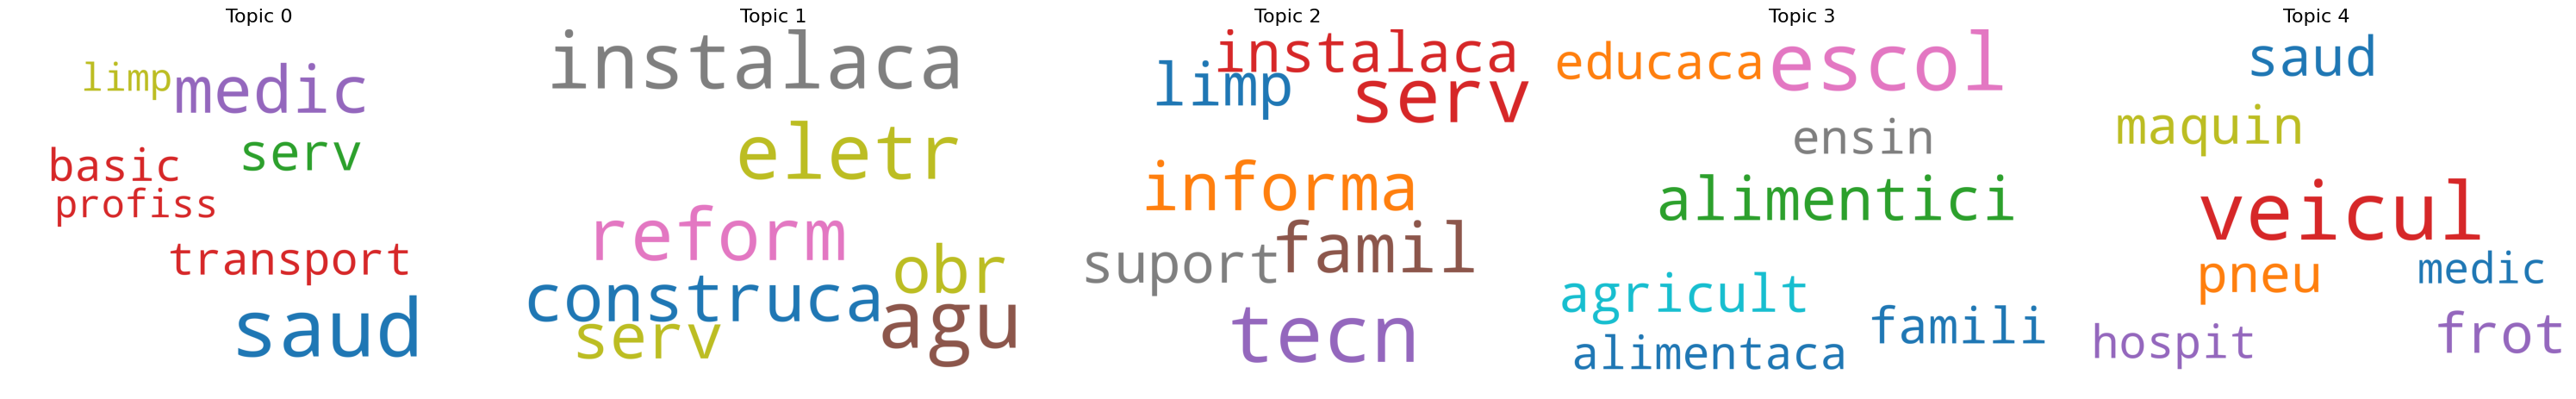

In [12]:
word_cloud(stop_words, lda_model, 5)

## PCA, T-SNE, UMAP Plot

In [6]:
doc_topic_probs = [lda_model[doc] for doc in corpus]

# Obtendo o tópico de maior probabilidade para cada documento
topTopics = [max(prob, key=lambda x: x[1])[0] for prob in [doc[0] for doc in doc_topic_probs]]

In [7]:
# converte o bag of words em sparse matrix
doc_topic_probs = lda_model.get_document_topics(corpus)
doc_topic_probs = corpus2csc(doc_topic_probs).T

In [66]:
# aplica o tsne
tsne_model = TSNE(n_components=2, random_state=42, init="random")
x = tsne_model.fit_transform(doc_topic_probs)

In [67]:
# cria o dataframe com os resultados
data = {
    'a': x[:, 0],
    'b': x[:, 1],
    'topic': topTopics
}
df_resultado = pd.DataFrame(data)

In [8]:
# pega as 3 palavras mais importantes de cada topico
top_words = []
for i in range(lda_model.num_topics):
    top_words.append(", ".join([word for word, _ in lda_model.show_topic(i, topn=3)]))

# adiciona isso pra plotar na legenda
topic_to_words = {i: words for i, words in enumerate(top_words)}
top_words_mapped = [topic_to_words[topic] if topic is not None else None for topic in topTopics]
# df_resultado["top_words"] = top_words_mapped

In [10]:
set(top_words_mapped)

{'eletr, hidraul, cont',
 'escol, alimentici, educaca',
 'limp, obr, predi',
 'rua, construca, pavimentaca',
 'saud, medic, famil',
 'serv, transport, instalaca',
 'veicul, maquin, frot'}

In [96]:
df_resultado

a           b  topic                    top_words
0        21.232878  110.844170      3           saud, medic, famil
1        74.722565   79.183716      6  rua, construca, pavimentaca
2       -31.413486   25.455610      4   escol, alimentici, educaca
3       -58.989353   52.575554      3           saud, medic, famil
4        48.215363  -16.501822      4   escol, alimentici, educaca
...            ...         ...    ...                          ...
128748 -116.584412   57.410980      3           saud, medic, famil
128749   25.593767  -50.252068      4   escol, alimentici, educaca
128750  -73.444771   91.776863      3           saud, medic, famil
128751  108.858185   24.985859      2   serv, transport, instalaca
128752  -54.559399   -6.198244      2   serv, transport, instalaca

[128753 rows x 4 columns]

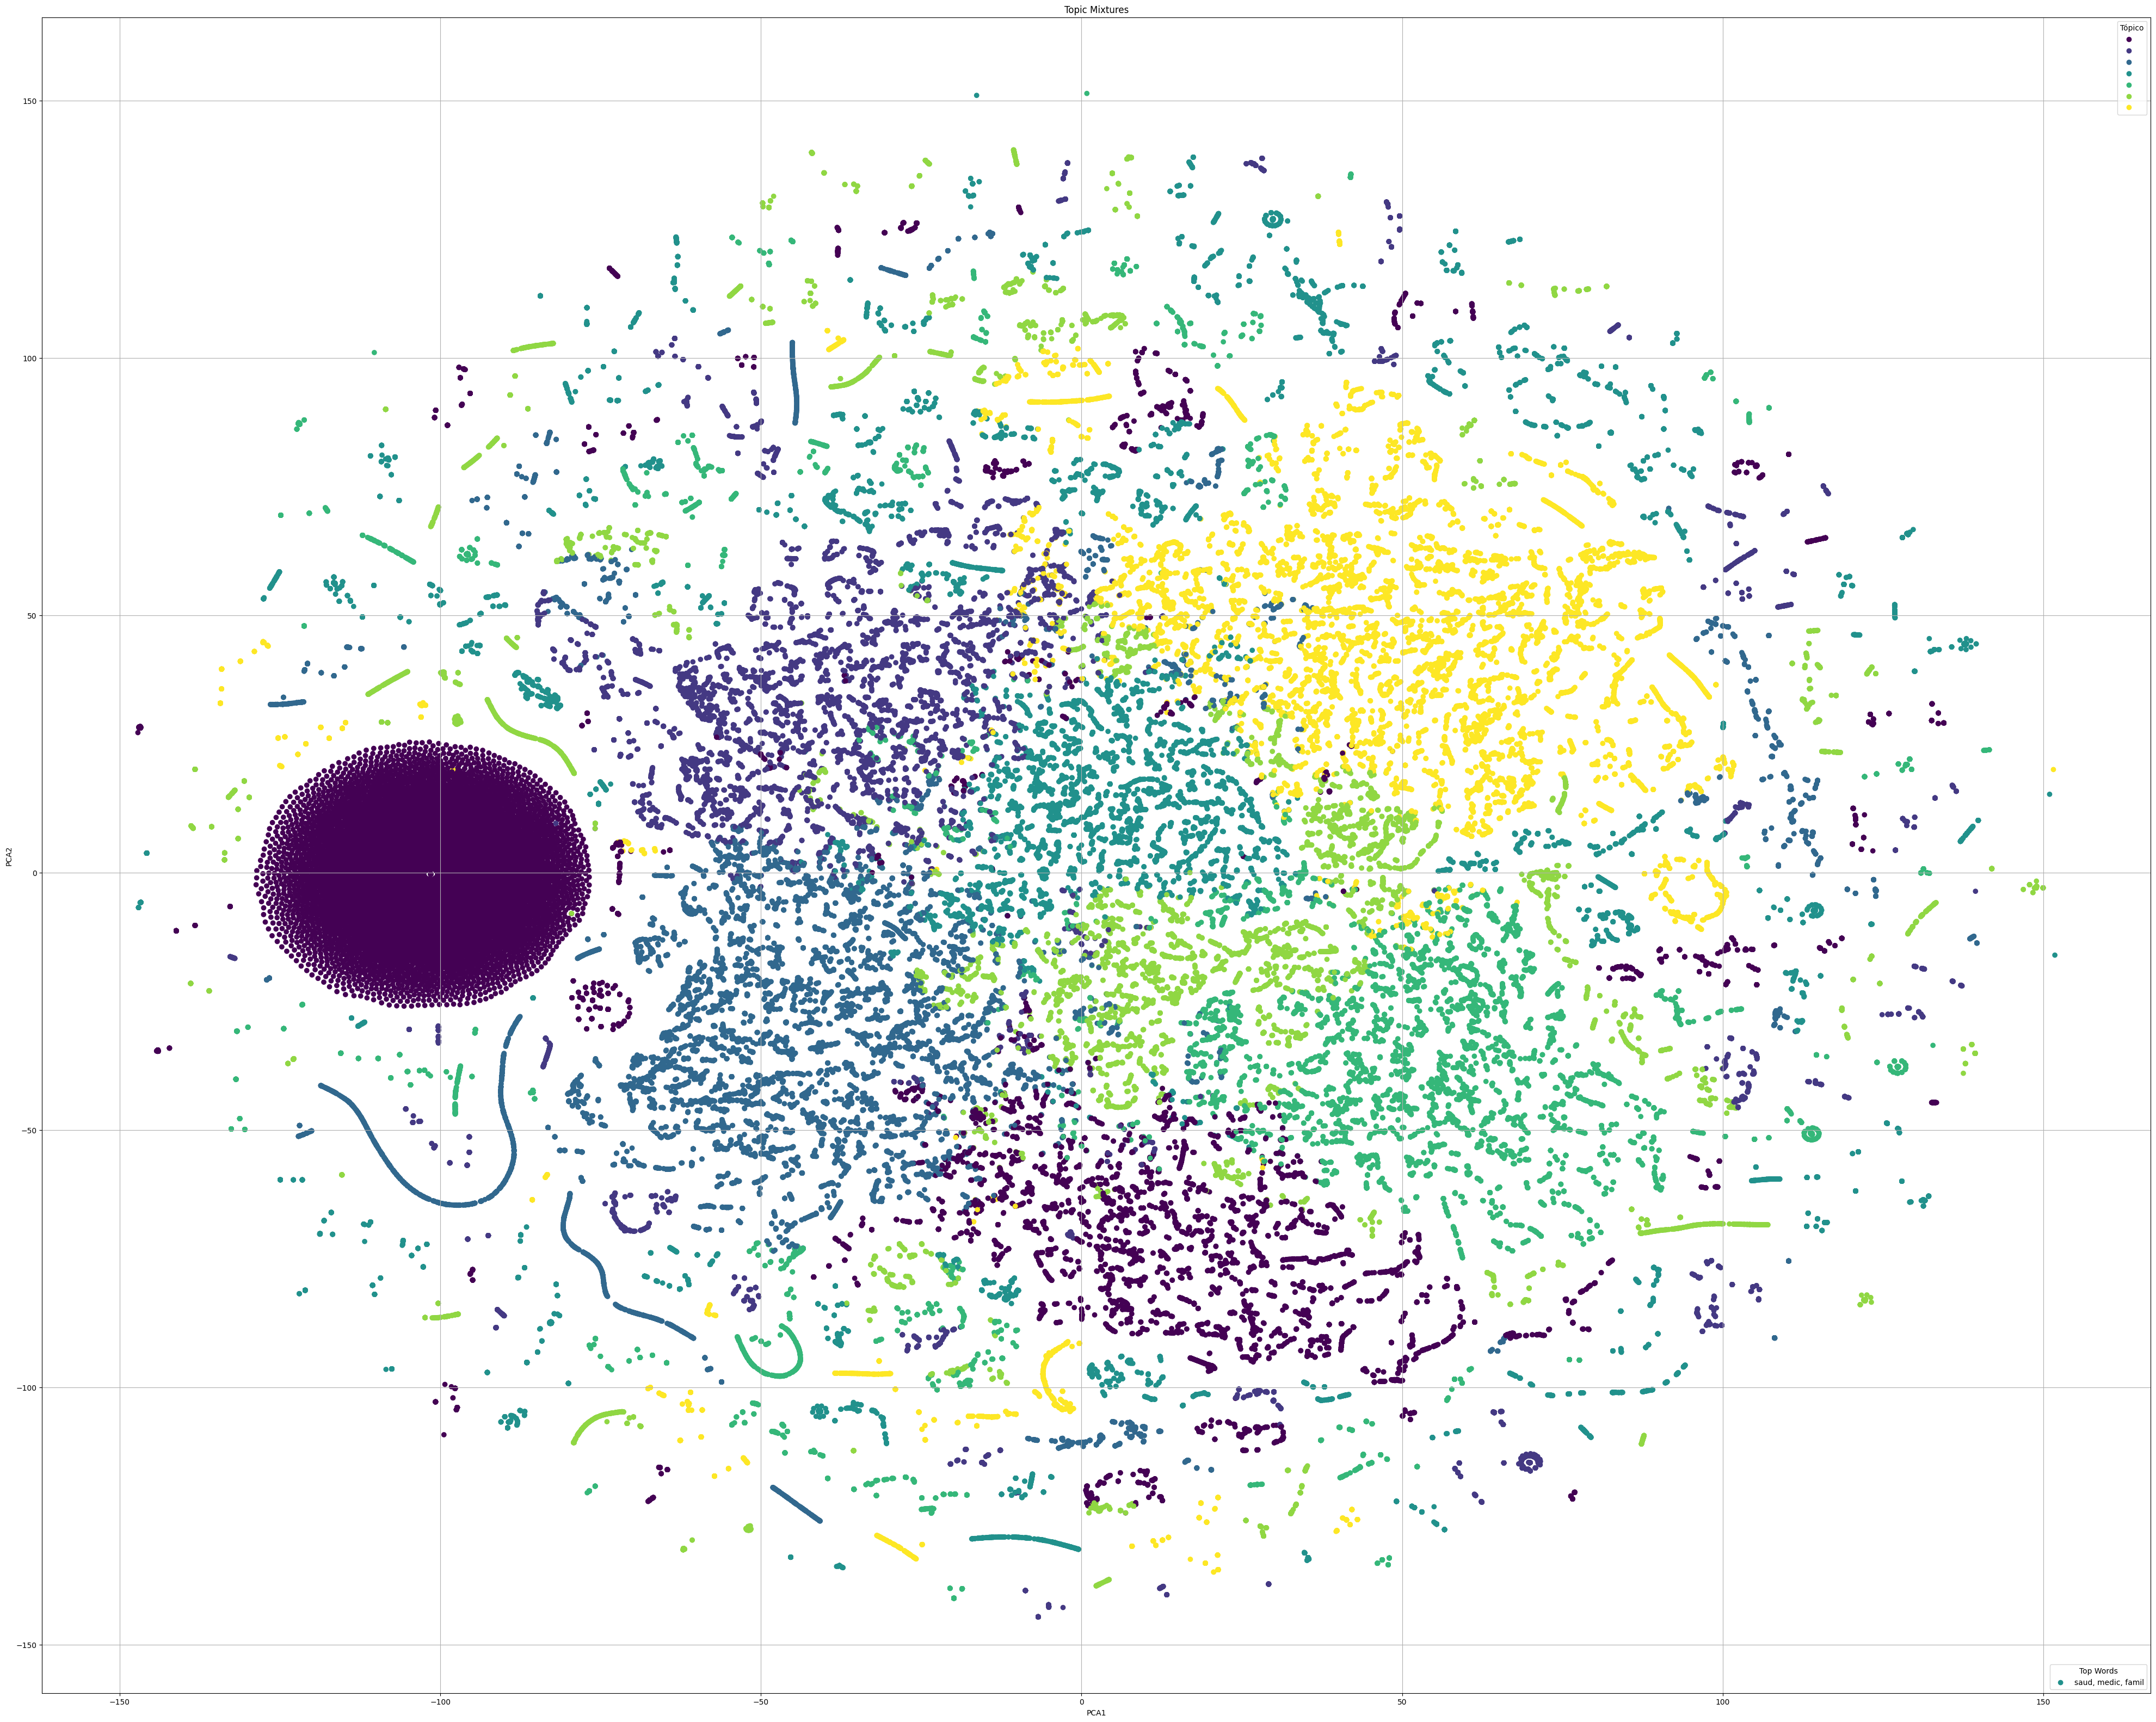

In [95]:
plt.figure(figsize=(50, 40))
scatter = plt.scatter(df_resultado["a"], df_resultado["b"], c=df_resultado["topic"], cmap='viridis')

# Adicionar legenda de top_words de acordo com o tópico
legend1 = plt.legend(handles=scatter.legend_elements()[0], title="Tópico", loc="upper right")
legend2 = plt.legend(df_resultado["top_words"].dropna().unique(), title="Top Words", loc="lower right")

plt.gca().add_artist(legend1)

plt.title("Topic Mixtures")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid(True)
plt.show()

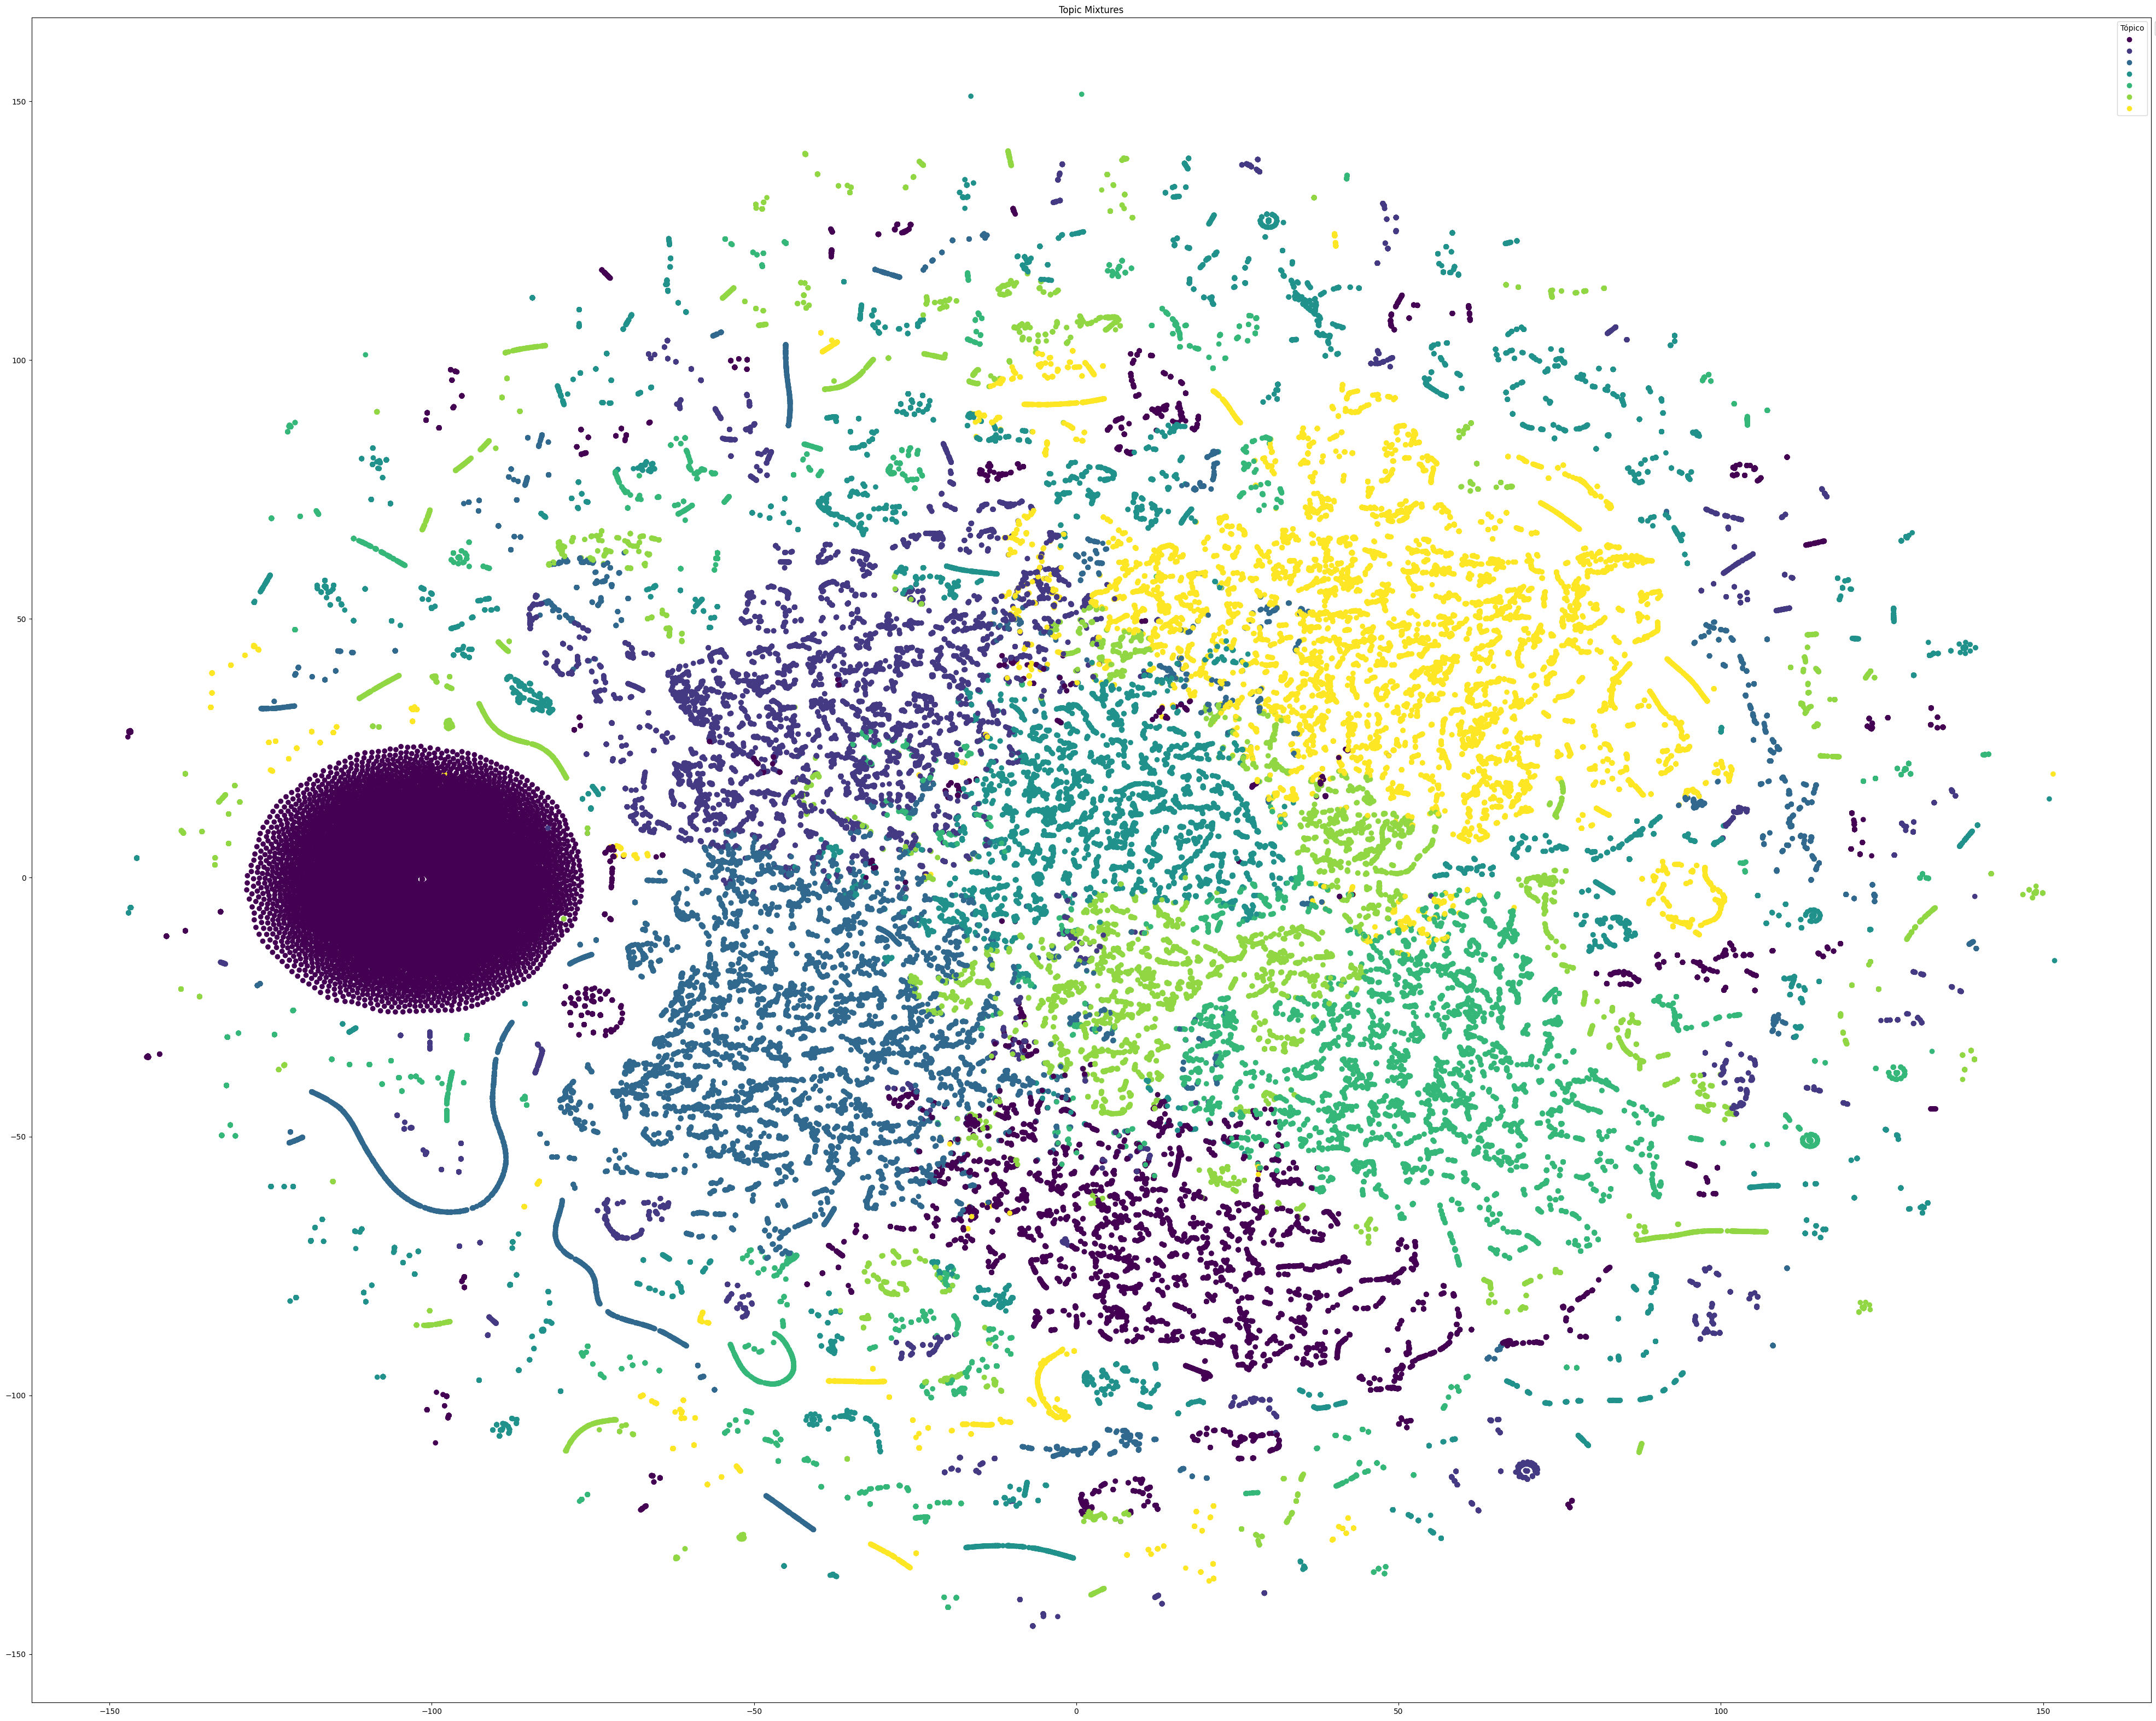

In [89]:
plt.figure(figsize=(50, 40))
scatter = plt.scatter(df_resultado["a"], df_resultado["b"], c=df_resultado["topic"], cmap='viridis')

# Adicionar legenda de top_words de acordo com o tópico
legend1 = plt.legend(handles=scatter.legend_elements()[0], title="Tópico")
legend2 = plt.legend(df_resultado["top_words"].dropna().unique(), loc='upper left', bbox_to_anchor=(1, 1))

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.title("Topic Mixtures")
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(lda_model.num_topics):
    plt.scatter(df_resultado[a == i, 0], df_resultado[b == i, 1], label=f"Topic {i}")

plt.title("Topic Mixtures")
plt.legend(title="Top Words", labels=df_resultado["topic"], loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()


In [86]:
df_resultado

a           b  topic                    top_words
0        21.232878  110.844170      3           saud, medic, famil
1        74.722565   79.183716      6  rua, construca, pavimentaca
2       -31.413486   25.455610      4   escol, alimentici, educaca
3       -58.989353   52.575554      3           saud, medic, famil
4        48.215363  -16.501822      4   escol, alimentici, educaca
...            ...         ...    ...                          ...
128748 -116.584412   57.410980      3           saud, medic, famil
128749   25.593767  -50.252068      4   escol, alimentici, educaca
128750  -73.444771   91.776863      3           saud, medic, famil
128751  108.858185   24.985859      2   serv, transport, instalaca
128752  -54.559399   -6.198244      2   serv, transport, instalaca

[128753 rows x 4 columns]

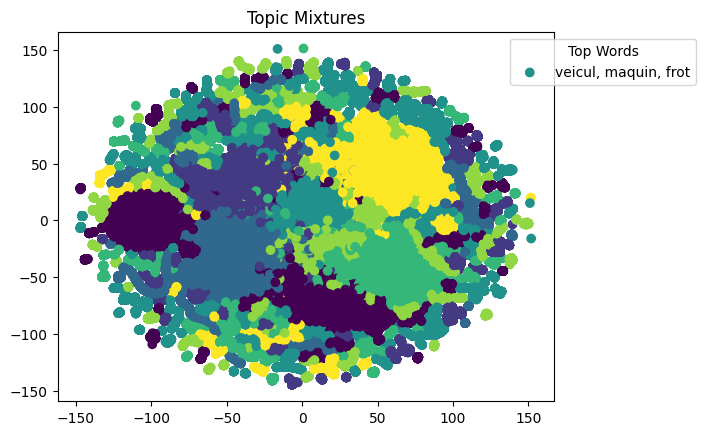

In [77]:

# Plotar as misturas de tópicos projetadas usando a função gscatter
plt.figure()
plt.scatter(df_resultado[["a"]], df_resultado[["b"]], c=topTopics)
plt.title("Topic Mixtures")
plt.show()

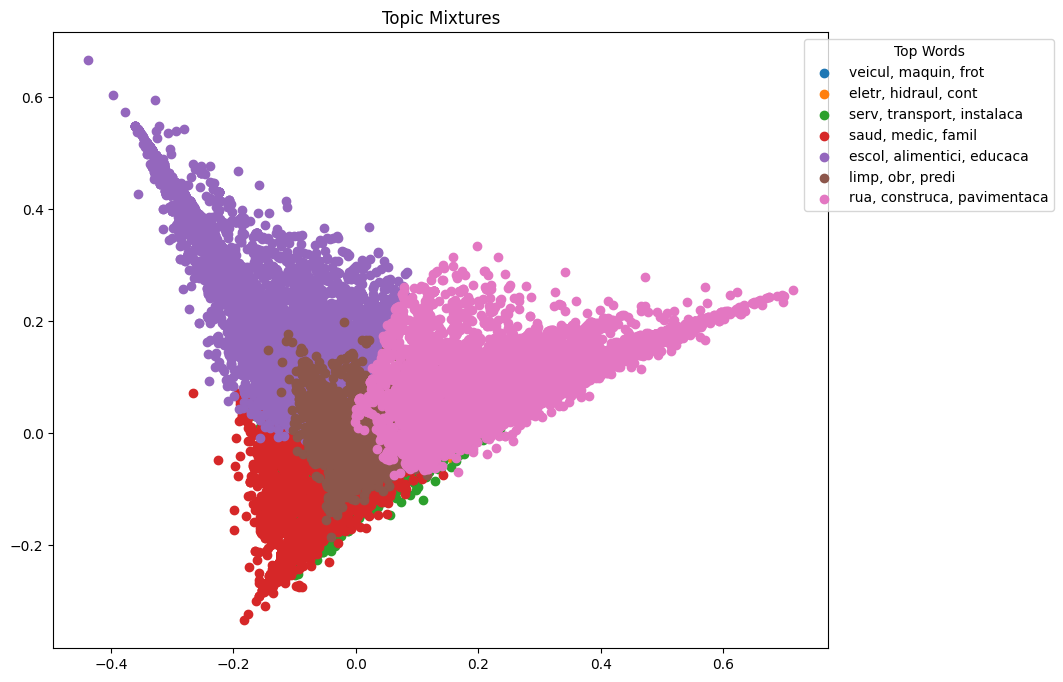

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Supondo que você já tenha lda_model, corpus, e id2word definidos

# Obtendo as probabilidades dos tópicos para cada documento
doc_topic_prob = [lda_model[doc] for doc in corpus]

# Convertendo as probabilidades em uma matriz numpy
doc_topic_matrix = np.zeros((len(doc_topic_prob), lda_model.num_topics))
for i, doc in enumerate(doc_topic_prob):
    for topic_prob in doc[0]:  # Acessando a primeira lista de tuplas (tópico, probabilidade)
        topic, prob = topic_prob
        doc_topic_matrix[i, topic] = prob

# Realizando a redução de dimensionalidade com PCA
pca = PCA(n_components=2)
doc_topic_pca = pca.fit_transform(doc_topic_matrix)

# Identificando os tópicos principais para cada documento
top_topics = np.argmax(doc_topic_matrix, axis=1)

# Encontrando as três palavras principais para cada tópico
top_words = []
for i in range(lda_model.num_topics):
    top_words.append(", ".join([word for word, _ in lda_model.show_topic(i, topn=3)]))

# Plotando os resultados com gscatter
plt.figure(figsize=(10, 8))
for i in range(lda_model.num_topics):
    plt.scatter(doc_topic_pca[top_topics == i, 0], doc_topic_pca[top_topics == i, 1], label=f"Topic {i}")

plt.title("Topic Mixtures")
plt.legend(title="Top Words", labels=top_words, loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()


In [ ]:
# Plotando os resultados com gscatter
plt.figure(figsize=(10, 8))
for i in range(lda_model.num_topics):
    plt.scatter(doc_topic_pca[top_topics == i, 0], doc_topic_pca[top_topics == i, 1], label=f"Topic {i}")

plt.title("Topic Mixtures")
plt.legend(title="Top Words", labels=top_words, loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()


In [70]:
def get_topic_distribution(lda_model, corpus):
    topic_dists = []

    for doc_bow in corpus:
        topic_dist = np.zeros(lda_model.num_topics)
        topics = lda_model.get_document_topics(doc_bow)
        for topic, prob in topics:
            topic_dist[topic] = prob
        topic_dists.append(topic_dist)

    return topic_dists

topic_distributions = get_topic_distribution(lda_model, corpus)

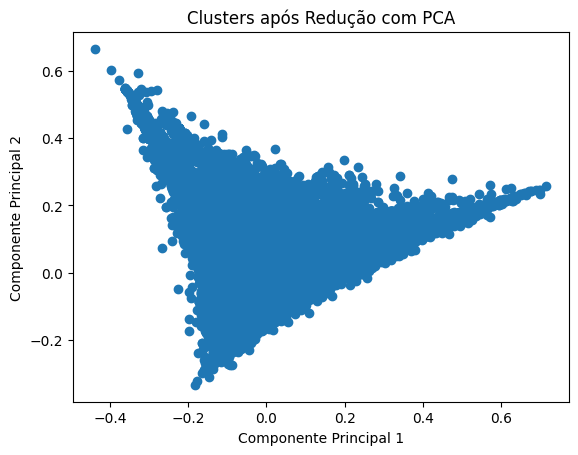

In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduzir a dimensão com PCA
pca = PCA(n_components=2)
topic_distributions_pca = pca.fit_transform(topic_distributions)

# Plotar os clusters
plt.scatter(topic_distributions_pca[:, 0], topic_distributions_pca[:, 1])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters após Redução com PCA')
plt.show()

In [75]:


def tsne_plot(lda_model: LdaMulticore, corpus: List, id2word: Dictionary) -> None:
    """
    Plots t-SNE visualization of LDA model topics.

    Parameters
    ----------
    lda_model : LdaMulticore
        Trained LDA model.
    corpus : List
        Corpus for the LDA model.
    id2word : Dictionary
        Gensim Dictionary for the corpus.
    """
    # Obtendo a matriz de tópicos para cada documento no corpus
    doc_topic_matrix = lda_model[corpus]

    # Criando uma lista de vetores de tópicos para cada documento
    topic_vectors = [np.array([prob for _, prob in lda_model.get_document_topics(doc)]) for doc in doc_topic_matrix]

    # Realizando a redução de dimensionalidade com t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    doc_topic_tsne = tsne.fit_transform(topic_vectors)

    # Identificando os tópicos principais para cada documento
    top_topics = np.argmax(topic_vectors, axis=1)

    # Encontrando as três palavras principais para cada tópico
    top_words = []
    for i in range(lda_model.num_topics):
        top_words.append(", ".join([word for word, _ in lda_model.show_topic(i, topn=3)]))

    # Plotando os resultados com matplotlib
    plt.figure(figsize=(10, 8))
    for i in range(lda_model.num_topics):
        plt.scatter(doc_topic_tsne[top_topics == i, 0], doc_topic_tsne[top_topics == i, 1], label=f"Topic {i}")

    plt.title("Visualização t-SNE dos Tópicos do Modelo LDA")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend(title="Top Palavras", labels=top_words, loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.show()


In [76]:
tsne_plot(lda_model, corpus, id2word)

ValueError: too many values to unpack (expected 2)

In [12]:
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

In [38]:
arr = pd.DataFrame(topic_weights).fillna(0).values

In [34]:
# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [34]:
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=vec, dictionary=id2word, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()


In [40]:
from sklearn.decomposition import PCA

In [29]:
import matplotlib.colors as mcolors

In [45]:
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])


In [46]:
mycolors

array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'], dtype='<U7')